In [1]:
!pip install -r requirements.txt

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%reload_ext autoreload

In [1]:
import sys

sys.path.append("src")
from wiki_bench import WikiBench
with open('Access_key.txt', 'r', encoding='utf-8') as file:
    url, key = file.read().split()
wiki_bench = WikiBench(url, key, model_name='yagpt5lite', pre_load=True)

resource module not available on Windows


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


In [2]:
with open('c.txt', 'r', encoding='utf-8') as file:
    names = file.read().split('\n')

In [4]:
print(names[500])

Байкал


In [ ]:
import shutil
import os

source_path = r'Articles\Sources'
err = []
succ = []
for name in names:
    try:
        page = wiki_bench.get_article(name=name, retrieve_sources=True, verbose=False, html=False, needs_saving=False)
        if len(page.downloaded_links) >= 25:
            succ.append(name)
            print(page.name)
        else:
            article_dir = os.path.join(source_path, page.cleared_name)
            if os.path.exists(article_dir) and os.path.isdir(article_dir):
                shutil.rmtree(article_dir)
    except:
        err.append(name)
        continue

Пригожин, Евгений Викторович
ЧВК «Вагнер»
Путин, Владимир Владимирович
Россия
Слово пацана. Кровь на асфальте
Государство Палестина
Король и Шут
Израиль
Сталин, Иосиф Виссарионович
Союз Советских Социалистических Республик
Президентские выборы в России (2024)
ChatGPT
Зеленский, Владимир Александрович
Список фильмов кинематографической вселенной Marvel
Криштиану Роналду
Москва
Atomic Heart
ХАМАС
Санкт-Петербург
Месси, Лионель
Shaman
Оппенгеймер (фильм)
Мятеж ЧВК «Вагнер»
Шойгу, Сергей Кужугетович
Ленин, Владимир Ильич
Российская империя
Китай
YouTube
Казахстан
Аватар: Путь воды
НАТО
Елизавета II
Кадыров, Рамзан Ахматович
Пугачёва, Алла Борисовна


C:\Users\dagri\anaconda3\envs\WIKIbench\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


Маск, Илон
Арабо-израильский конфликт
Великобритания


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Германия
Байден, Джо
Цой, Виктор Робертович
Одни из нас (телесериал)
БРИКС
Ди Каприо, Леонардо
Стрелков, Игорь Иванович
Википедия
Корейская Народно-Демократическая Республика
Землетрясение в Турции и Сирии (2023)
Террористический акт в Беслане
Приднестровская Молдавская Республика
Титаник
Вызов (фильм, 2023)
Афганская война (1979—1989)
Террористические акты 11 сентября 2001 года
Азербайджан
Толстой, Лев Николаевич
Хрущёв, Никита Сергеевич
Горбачёв, Михаил Сергеевич
Марцинкевич, Максим Сергеевич
Лукашенко, Александр Григорьевич
2023 год


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Искандер (ракетный комплекс)
Прилепин, Захар
General Dynamics F-16 Fighting Falcon
Су-57
Кабаева, Алина Маратовна
Игра престолов (телесериал)
Telegram
Медведев, Дмитрий Анатольевич
Вооружённые силы Российской Федерации
Екатеринбург


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Канада
Армения
Minecraft
Калининград
ВКонтакте
Мэрилин Монро


In [12]:
from newspaper import Article

article = Article('https://www.britannica.com/topic/European-Union', language='en')
article.download()
article.parse()
text = article.text
len(text)

2029

In [1]:
import sys

sys.path.append("src")
from wiki_bench import WikiBench

resource module not available on Windows


In [2]:
with open('Access_key.txt', 'r', encoding='utf-8') as file:
    url, key = file.read().split()

In [3]:
wiki_bench = WikiBench(url, key, model_name='yagpt5lite', pre_load=True)

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


In [7]:
lst = list(await wiki_bench.client.client.models.list())[0][1]
for l in lst:
    print(l)

Model(id='deepseek-r1-32b', created=None, object=None, owned_by=None, max_model_len=30000, status='spawned')
Model(id='tpro', created=None, object=None, owned_by=None, max_model_len=30000, status='spawned')
Model(id='yagpt5lite', created=None, object=None, owned_by=None, max_model_len=30000, status='spawned')
Model(id='RefalMachine/RuadaptQwen2.5-32B-Pro-Beta', created=None, object=None, owned_by=None, max_model_len=28000, status='spawned')
Model(id='llama3-70b', created=None, object=None, owned_by=None, max_model_len=14000, status='spawned')
Model(id='qwen2.5-72b', created=None, object=None, owned_by=None, max_model_len=14000, status='spawned')
Model(id='DeepSeek V3', created=None, object=None, owned_by=None, max_model_len=-1, status='spawned')
Model(id='Qwen3-235B-A22B', created=None, object=None, owned_by=None, max_model_len=-1, status='spawned')
Model(id='RefalMachine/RuadaptQwen2.5-7B-Garant-v2', created=None, object=None, owned_by=None, max_model_len=30000, status='offloaded')
Mo

In [2]:
ndcg, pr = await wiki_bench.rank_query(reference_mode=0)

C++


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.5117420056466501
0.125

COVID-19


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.7270792028266624
0.10187110187110188

Dota 2


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.616165193008634
0.03076923076923077

Google (компания)


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.6437873324358534
0.23300970873786409

Portal 2


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.702271277504201
0.1276595744680851

Python


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.7843599264225529
0.233278955954323

TikTok


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.6718742398955954
0.09271523178807947

Tomb Raider (игра, 2013)


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.732102519498849
0.20853080568720378

Uncharted 4 A Thief’s End


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.6574424218175681
0.21929824561403508

YouTube


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.6116923425010674
0.15517241379310345

Большой адронный коллайдер


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.550274758004911
0.09302325581395349

Вирус иммунодефицита человека


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.7160548241790096
0.1836734693877551

Геморрагическая лихорадка Эбола


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.6779439451394341
0.12903225806451613

Иннополис


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.6389928616564351
0.16923076923076924

Искусственный интеллект


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.5925482186749249
0.1111111111111111

Квантовый компьютер


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.6573901353984734
0.0967741935483871

Летние Олимпийские игры 2020


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.45031625524559565
0.18181818181818182

Летние Олимпийские игры 2024


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.7348735246482192
0.19696969696969696

Марс


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.7219517667440942
0.23333333333333334

Применение искусственного интеллекта


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.7503326497977469
0.29333333333333333

Присоединение Крыма к Российской Федерации


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.8542285704191281
0.37209302325581395

РИА Новости


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.6013684970702922
0.16666666666666666

Сбербанк России


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.8279230995145391
0.3815028901734104

Си (язык программирования)


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.7120568529278237
0.36018957345971564

Сколково (инновационный центр)


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.7978885510628093
0.32819383259911894

Солнечная система


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.6536643600580939
0.21008403361344538

Чёрная дыра


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.8230329706278424
0.26570048309178745

Чёрная смерть


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.8465493212892908
0.3333333333333333

Экономика КНР


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.8075327550477744
0.3717948717948718

Экономика США


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.4559764191681722
0.16666666666666666

Яндекс


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

0.7201728220301189
0.1743119266055046



In [4]:
print(ndcg, pr)

0.6854706329116891 0.20471426363078707


In [5]:
await wiki_bench.rank_sections()

Python
Generated for section:  ('h3', 'Выражения')
Generated for section:  ('h2', 'Парадигмы программирования')
Generated for section:  ('h3', 'Обобщённое программирование')
Generated for section:  ('h2', 'Применение')
Generated for section:  ('h2', 'Концепция и философия')
Generated for section:  ('h2', 'История')
Generated for section:  ('h3', 'Объектно-ориентированное программирование')
Generated for section:  ('h1', 'Python')
Generated for section:  ('h3', 'Строки документации')
Generated for section:  ('h3', 'Графические библиотеки')
Generated for section:  ('h3', 'Модули расширения и программные интерфейсы')
Generated for section:  ('h2', 'Типы и структуры данных')
Generated for section:  ('h3', 'Регулярные выражения')
Generated for section:  ('h2', 'Профилирование и оптимизация кода')
Generated for section:  ('h3', 'Perl')
Generated for section:  ('h3', 'Глобальная блокировка интерпретатора (GIL)')
Generated for section:  ('h2', 'Сравнение с другими языками')
Generated for secti

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Летние Олимпийские игры 2024
Generated for section:  ('h2', 'Заявочный процесс')
Generated for section:  ('h3', 'Эмблема')
Generated for section:  ('h2', 'Олимпийская деревня')
Generated for section:  ('h3', 'Слоган')
Generated for section:  ('h3', 'Талисман')
Generated for section:  ('h2', 'Участники')
Generated for section:  ('h2', 'Дополнительная информация')
Generated for section:  ('h2', 'Реклама')
Generated for section:  ('h2', 'Безопасность')
Generated for section:  ('h2', 'Мирные инициативы')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Квантовый компьютер
Generated for section:  ('h3', 'Исследования в области искусственного интеллекта')
Generated for section:  ('h2', 'Физические реализации квантовых компьютеров')
Generated for section:  ('h3', 'Молекулярное моделирование')
Generated for section:  ('h3', 'Приложения к криптографии')
Generated for section:  ('h1', 'Квантовый компьютер')
Generated for section:  ('h3', 'Экспериментальные образцы')
Generated for section:  ('h3', 'Адиабатические компьютеры D-Wave')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Присоединение Крыма к Российской Федерации
Generated for section:  ('h3', 'Международные отношения')
Generated for section:  ('h2', 'В культуре')
Generated for section:  ('h2', 'Предыстория')
Generated for section:  ('h1', 'Присоединение Крыма к Российской Федерации')
Generated for section:  ('h2', 'Решающие события')
Generated for section:  ('h3', 'Фильмы')
Generated for section:  ('h3', 'Торжественные мероприятия')
Generated for section:  ('h3', 'Памятники')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Сколково (инновационный центр)
Generated for section:  ('h3', 'Идея проекта')
Generated for section:  ('h1', 'Сколково (инновационный центр)')
Generated for section:  ('h2', 'Описание')
Generated for section:  ('h3', 'Ликвидация местного самоуправления и особый правовой режим')
Generated for section:  ('h4', '2019')
Generated for section:  ('h4', '2010')
Generated for section:  ('h3', 'Налоговый и правовой режим')
Generated for section:  ('h4', '2012')
Generated for section:  ('h4', '2011')
Generated for section:  ('h4', '2014')
Generated for section:  ('h4', '2013')
Generated for section:  ('h5', 'Дело Бельтюкова и Пономарёва')
Generated for section:  ('h5', 'Дело Луговцева и Хохлова')
Generated for section:  ('h5', 'Причины и последствия')
Generated for section:  ('h3', 'Региональные операторы')
Generated for section:  ('h4', '2015')
Generated for section:  ('h4', '2020')
Generated for section:  ('h3', 'Skolkovo Ventures')
Generated for section:  ('h2', 'Перспективы')
Generated for s

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Tomb Raider (игра, 2013)
Generated for section:  ('h3', 'Отзывы о дебютном трейлере')
Generated for section:  ('h3', 'Слухи, анонс и выпуск')
Generated for section:  ('h3', 'Производство и выпуск')
Generated for section:  ('h3', 'Влияние')
Generated for section:  ('h3', 'Производственный процесс')
Generated for section:  ('h3', 'Основы')
Generated for section:  ('h3', 'Технические особенности')
Generated for section:  ('h3', 'Боевая система')
Generated for section:  ('h3', 'Описание')
Generated for section:  ('h2', 'Сиквел и дополнения')
Generated for section:  ('h3', 'Концепция')
Generated for section:  ('h3', 'Персонажи')
Generated for section:  ('h3', 'Реакция на перезагрузку')
Generated for section:  ('h3', 'Создатели')
Generated for section:  ('h3', 'Навигация')
Generated for section:  ('h3', 'Издания и продажи')
Generated for section:  ('h2', 'Экранизация')
Generated for section:  ('h3', 'Сопутствующая продукция и проекты')
Generated for section:  ('h3', 'Цифровая выставка')
Gene

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Чёрная дыра
Generated for section:  ('h2', 'Этимология')
Generated for section:  ('h3', '«Чёрная звезда» Мичелла (1784—1796)')
Generated for section:  ('h4', 'Основные свойства')
Generated for section:  ('h2', 'Описание')
Generated for section:  ('h3', 'От Мичелла до Шварцшильда (1796—1915)')
Generated for section:  ('h3', 'Решение Рейснера\xa0— Нордстрёма')
Generated for section:  ('h3', 'Решение Керра')
Generated for section:  ('h4', 'Заключительные стадии испарения чёрной дыры')
Generated for section:  ('h3', 'Сверхмассивные чёрные дыры')
Generated for section:  ('h2', 'Модель на базе теории струн')
Generated for section:  ('h2', 'Чёрные дыры во Вселенной')
Generated for section:  ('h3', 'Чёрные дыры звёздных масс')
Generated for section:  ('h2', 'Падение в чёрную дыру')
Generated for section:  ('h4', 'Возмущения горизонта событий и их затухание')
Generated for section:  ('h4', 'Измерение скорости микроволновых источников')
Generated for section:  ('h4', 'Излучение Хокинга')
Generat

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Экономика США
Generated for section:  ('h2', 'Экономика')
Generated for section:  ('h1', 'Экономика США')
Generated for section:  ('h4', 'Ипотечный кризис 2007\xa0года')
Generated for section:  ('h2', 'Военно-промышленный комплекс США')
Generated for section:  ('h3', '2020-е')
Generated for section:  ('h3', 'Добыча нефти и газа')
Generated for section:  ('h2', 'Бедность')
Generated for section:  ('h2', 'Международная торговля (импорт и экспорт)')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Искусственный интеллект
Generated for section:  ('h3', 'Финансы')
Generated for section:  ('h2', 'Сложности в перспективе')
Generated for section:  ('h4', 'Исследования рынка и интеллектуальный анализ данных')
Generated for section:  ('h4', 'Алгоритмическая торговля')
Generated for section:  ('h3', 'Известные системы искусственного интеллекта')
Generated for section:  ('h3', 'История развития искусственного интеллекта в СССР и России')
Generated for section:  ('h3', 'Музыка')
Generated for section:  ('h4', 'Банкинг')
Generated for section:  ('h3', 'Государственное управление')
Generated for section:  ('h3', 'Развлечение и игры')
Generated for section:  ('h3', 'Онлайн и телефонные службы поддержки клиентов')
Generated for section:  ('h3', 'Военное дело')
Generated for section:  ('h3', 'Новости, издательство и писательство')
Generated for section:  ('h3', 'Психология и когнитология')
Generated for section:  ('h3', 'Иные области применения')
Generated for section:  ('h3', 'Пенитенциарная 

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


COVID-19
Generated for section:  ('h2', 'Диагностика')
Generated for section:  ('h3', 'Передача инфекции')
Generated for section:  ('h2', 'Эпидемиология')
Generated for section:  ('h2', 'Постковидный синдром')
Generated for section:  ('h2', 'Лечение')
Generated for section:  ('h2', 'Клиническая картина')
Generated for section:  ('h3', 'Патогенез')
Generated for section:  ('h1', 'COVID-19')
Generated for section:  ('h4', 'Средства против синдрома высвобождения цитокинов')
Generated for section:  ('h2', 'ВОЗ о ситуации с COVID-19 на конец 2023\xa0года')
Generated for section:  ('h3', 'Экспериментальное лечение')
Generated for section:  ('h3', 'Вирусология')
Generated for section:  ('h4', 'Рекомендации для здоровых')
Generated for section:  ('h2', 'Прогноз')
Generated for section:  ('h4', 'Рекомендации для медицинских работников')
Generated for section:  ('h3', 'Осложнения')
Generated for section:  ('h3', 'Иммунитет')
Generated for section:  ('h3', 'Диагностические показатели и биомаркеры

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Применение искусственного интеллекта
Generated for section:  ('h3', 'Таргетированная реклама и повышение активности в Интернете')
Generated for section:  ('h3', 'Фильтрация спама')
Generated for section:  ('h3', 'Машинный перевод')
Generated for section:  ('h2', 'Образование')
Generated for section:  ('h2', 'Игры')
Generated for section:  ('h3', 'Биохимия')
Generated for section:  ('h3', 'Техника безопасности')
Generated for section:  ('h2', 'Финансы')
Generated for section:  ('h3', 'Обратная инженерия')
Generated for section:  ('h2', 'Вооружения')
Generated for section:  ('h2', 'Химия и биология')
Generated for section:  ('h3', 'Торговля и инвестиции')
Generated for section:  ('h2', 'Здравоохранение')
Generated for section:  ('h3', 'Юридический анализ')
Generated for section:  ('h3', 'Физика')
Generated for section:  ('h3', 'Биологические вычисления в ИИ и подобно ИИ')
Generated for section:  ('h3', 'Новые типы машинного обучения')
Generated for section:  ('h3', 'Поиск внеземных цивил

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


РИА Новости
Generated for section:  ('h3', 'RIA.ru')
Generated for section:  ('h3', 'РИА «Новости» с 2014 года по настоящее время')
Generated for section:  ('h3', 'Совинформбюро')
Generated for section:  ('h3', 'РИА «Вести» и РИА «Новости»')
Generated for section:  ('h3', 'Агентство печати «Новости»')
Generated for section:  ('h3', 'РИА «Новости» до 2013 года')
Generated for section:  ('h1', 'РИА Новости')
Generated for section:  ('h2', 'Ликвидация ФГУП РАМИ «РИА Новости»')
Generated for section:  ('h3', 'Блокировка в Канаде')
Generated for section:  ('h3', 'Блокировка в ЕС')
Generated for section:  ('h3', 'РАПСИ')
Generated for section:  ('h3', 'РИА Рейтинг')
Generated for section:  ('h3', 'Блокировка в Азербайджане')
Generated for section:  ('h3', 'The Moscow News')
Generated for section:  ('h2', 'Журналисты, погибшие или пострадавшие при исполнении профессионального долга')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Uncharted 4: A Thief’s End
Generated for section:  ('h1', 'Uncharted 4: A Thief’s End')
Generated for section:  ('h2', 'Отзывы и награды')
Generated for section:  ('h2', 'Разработка')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Экономика КНР
Generated for section:  ('h3', 'Нефть и газ')
Generated for section:  ('h3', 'Руды металлов')
Generated for section:  ('h2', 'Сельское хозяйство')
Generated for section:  ('h2', 'Экономические показатели')
Generated for section:  ('h2', 'Общая информация')
Generated for section:  ('h3', 'XX\xa0век')
Generated for section:  ('h3', 'XXI\xa0век')
Generated for section:  ('h2', 'Минеральные ресурсы')
Generated for section:  ('h2', 'Частный сектор')
Generated for section:  ('h3', 'Лёгкая промышленность')
Generated for section:  ('h3', 'Электронная промышленность')
Generated for section:  ('h2', 'Промышленность')
Generated for section:  ('h2', 'Доходы населения')
Generated for section:  ('h3', 'Машиностроение')
Generated for section:  ('h3', 'с Центральной Азией')
Generated for section:  ('h3', 'с Австралией')
Generated for section:  ('h3', 'с АСЕАН')
Generated for section:  ('h3', 'Металлургия')
Generated for section:  ('h2', 'Сфера услуг')
Generated for section:  ('h3', 'с Ре

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Иннополис
Generated for section:  ('h2', 'Культура и спорт')
Generated for section:  ('h3', 'Городской бюджет')
Generated for section:  ('h3', 'Административное устройство')
Generated for section:  ('h3', 'Университет Иннополис')
Generated for section:  ('h3', 'Начало строительства')
Generated for section:  ('h3', 'Проект города')
Generated for section:  ('h3', 'Городская инфраструктура')
Generated for section:  ('h3', 'История названия')
Generated for section:  ('h2', 'Здравоохранение')
Generated for section:  ('h3', 'Органы власти')
Generated for section:  ('h3', 'Открытие города')
Generated for section:  ('h3', 'Особая экономическая зона')
Generated for section:  ('h3', 'Транспорт')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Летние Олимпийские игры 2020
Generated for section:  ('h2', 'Пандемия COVID-19 и Игры')
Generated for section:  ('h2', 'Олимпийский комитет России')
Generated for section:  ('h1', 'Летние Олимпийские игры 2020')
Generated for section:  ('h2', 'Случай с белорусской спортсменкой')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Солнечная система
Generated for section:  ('h4', 'Межпланетная среда')
Generated for section:  ('h5', 'Юпитер')
Generated for section:  ('h2', 'Галактическая орбита')
Generated for section:  ('h4', 'Пояс астероидов')
Generated for section:  ('h2', 'Структура')
Generated for section:  ('h3', 'Терминология')
Generated for section:  ('h4', 'Гелиосфера')
Generated for section:  ('h5', 'Девятая планета')
Generated for section:  ('h5', 'Рассеянный диск')
Generated for section:  ('h5', 'Церера')
Generated for section:  ('h4', 'Кометы')
Generated for section:  ('h5', 'Меркурий')
Generated for section:  ('h4', 'Планеты земной группы')
Generated for section:  ('h2', '«Открытие» и исследование')
Generated for section:  ('h3', 'Геоцентрическая и гелиоцентрическая системы')
Generated for section:  ('h2', 'Формирование и эволюция')
Generated for section:  ('h4', 'Облако Оорта')
Generated for section:  ('h5', 'Седна')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


C++
Generated for section:  ('h3', 'Общие направления развития C++')
Generated for section:  ('h4', 'Результирующий объём исполнимого кода')
Generated for section:  ('h3', 'Развитие и стандартизация языка')
Generated for section:  ('h3', 'C++ и Java')
Generated for section:  ('h2', 'Влияние и альтернативы')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Си (язык программирования)
Generated for section:  ('h2', 'Синтаксис и семантика')
Generated for section:  ('h4', 'Вспомогательные целочисленные типы')
Generated for section:  ('h4', 'Приведение целочисленных типов')
Generated for section:  ('h4', 'Целые числа')
Generated for section:  ('h2', 'Препроцессор')
Generated for section:  ('h4', 'Отсутствие контроля над адресной арифметикой')
Generated for section:  ('h4', 'Массивы')
Generated for section:  ('h4', 'Структуры')
Generated for section:  ('h4', 'Широкие строки')
Generated for section:  ('h4', 'Неэффективные и небезопасные строки')
Generated for section:  ('h4', 'Модули')
Generated for section:  ('h4', 'Возврат кода ошибки')
Generated for section:  ('h4', 'Отсутствие унификации обработки ошибок')
Generated for section:  ('h4', 'Ошибки в математических функциях')
Generated for section:  ('h4', 'Освобождение ресурсов')
Generated for section:  ('h4', 'Маркеры ошибок и errno')
Generated for section:  ('h4', 'Стандарты POSIX')
Generate

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Сбербанк России
Generated for section:  ('h3', '2010—2019')
Generated for section:  ('h2', 'История')
Generated for section:  ('h1', 'Сбербанк России')
Generated for section:  ('h2', 'Деятельность')
Generated for section:  ('h3', '2020\xa0год\xa0— н.\u2009в.')
Generated for section:  ('h3', 'Слияния и поглощения. Дочерние проекты')
Generated for section:  ('h3', 'Показатели деятельности')
Generated for section:  ('h3', 'Мошеннические прозвоны и рассылки')
Generated for section:  ('h2', 'Санкции')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Чёрная смерть
Generated for section:  ('h1', 'Чёрная смерть')
Generated for section:  ('h2', 'Альтернативные теории')
Generated for section:  ('h3', 'Климатический фактор')
Generated for section:  ('h2', 'Начало эпидемии')
Generated for section:  ('h2', 'Эпидемиология')
Generated for section:  ('h2', 'Хроника распространения чумы')
Generated for section:  ('h3', 'Католическая церковь и чума')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Яндекс
Generated for section:  ('h3', '«Яндекс. Маркет»')
Generated for section:  ('h3', 'Такси')
Generated for section:  ('h3', 'Медиасервисы')
Generated for section:  ('h3', 'Вертикали')
Generated for section:  ('h3', 'Поиск и портал')
Generated for section:  ('h2', 'Сервисы, службы и приложения')
Generated for section:  ('h1', 'Яндекс')
Generated for section:  ('h3', 'Технологии искусственного интеллекта')
Generated for section:  ('h3', 'Логотип')
Generated for section:  ('h2', 'Статистика и финансовые показатели')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Google (компания)
Generated for section:  ('h3', 'Рост')
Generated for section:  ('h3', 'Поисковая система')
Generated for section:  ('h3', 'Приобретения и партнёрства')
Generated for section:  ('h1', 'Google (компания)')
Generated for section:  ('h3', 'Финансирование и первичное публичное предложение')
Generated for section:  ('h3', 'Другие сервисы')
Generated for section:  ('h3', 'Цензура в компании')
Generated for section:  ('h3', 'Нарушение права на неприкосновенность частной жизни')
Generated for section:  ('h3', 'Санкции Европейской комиссии')
Generated for section:  ('h3', 'Штрафы, суды, расследования')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Большой адронный коллайдер
Generated for section:  ('h4', '2022 (Run3)')
Generated for section:  ('h4', '2009—2014 годы. Работа на пониженной энергии (Run1)')
Generated for section:  ('h1', 'Большой адронный коллайдер')
Generated for section:  ('h4', '2008 год. Запуск. Авария')
Generated for section:  ('h3', 'Детекторы')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Геморрагическая лихорадка Эбола
Generated for section:  ('h3', 'Кровотечение')
Generated for section:  ('h3', 'События XXI\xa0века')
Generated for section:  ('h2', 'Описание')
Generated for section:  ('h1', 'Геморрагическая лихорадка Эбола')
Generated for section:  ('h2', 'Эпидемиология')
Generated for section:  ('h2', 'Последствия болезни')
Generated for section:  ('h3', 'Препараты без доказанной эффективности')
Generated for section:  ('h2', 'Патогенез')
Generated for section:  ('h2', 'Лечение')
Generated for section:  ('h3', 'Вакцины')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Вирус иммунодефицита человека
Generated for section:  ('h2', 'Геном и кодируемые белки')
Generated for section:  ('h2', 'Строение вириона')
Generated for section:  ('h3', 'Проникновение в клетку и обратная транскрипция')
Generated for section:  ('h2', 'Классификация')
Generated for section:  ('h1', 'Вирус иммунодефицита человека')
Generated for section:  ('h3', 'Лечение')
Generated for section:  ('h2', 'Открытие ВИЧ')
Generated for section:  ('h3', 'Препараты для профилактики')
Generated for section:  ('h3', 'Диагностика')
Generated for section:  ('h3', 'Nef')
Generated for section:  ('h3', 'Vpu')
Generated for section:  ('h3', 'ВИЧ-2')
Generated for section:  ('h3', 'Естественная устойчивость к ВИЧ')
Generated for section:  ('h2', 'Происхождение')
Generated for section:  ('h3', 'Распространение по организму')
Generated for section:  ('h3', 'Транскрипция, сплайсинг, транспорт РНК из ядра в цитоплазму и трансляция')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Dota 2
Generated for section:  ('h2', 'Судебные разбирательства')
Generated for section:  ('h2', 'Выход')
Generated for section:  ('h2', 'Игры человека против компьютера')
Generated for section:  ('h1', 'Dota 2')
Generated for section:  ('h2', 'Разработка')
Generated for section:  ('h2', 'Отзывы')
Generated for section:  ('h2', 'Игровой процесс')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


TikTok
Generated for section:  ('h3', 'Незаконный сбор данных')
Generated for section:  ('h1', 'TikTok')
Generated for section:  ('h3', 'Продажа американского сегмента TikTok')
Generated for section:  ('h2', 'История')
Generated for section:  ('h4', 'США')
Generated for section:  ('h4', 'Российская Федерация')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Марс
Generated for section:  ('h3', 'Атмосферное давление')
Generated for section:  ('h3', 'В античной мифологии')
Generated for section:  ('h2', 'Атмосфера и климат')
Generated for section:  ('h3', 'Времена года на Марсе')
Generated for section:  ('h2', 'Орбитальные характеристики')
Generated for section:  ('h3', 'Климат')
Generated for section:  ('h3', 'Параметры планеты')
Generated for section:  ('h3', 'Сила тяжести')
Generated for section:  ('h3', 'Пылевые бури и пыльные вихри')
Generated for section:  ('h3', 'Гидросфера Марса')
Generated for section:  ('h2', 'Геология и внутреннее строение')
Generated for section:  ('h3', 'Грунт')
Generated for section:  ('h2', 'Основные сведения')
Generated for section:  ('h2', 'Поверхность')
Generated for section:  ('h3', 'Лёд и полярные шапки')
Generated for section:  ('h2', 'Вопрос о праве собственности на планету и её участки')
Generated for section:  ('h2', 'В культуре')
Generated for section:  ('h3', 'Колонизация Марса')
Generated for secti

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


YouTube
Generated for section:  ('h3', 'Реклама')
Generated for section:  ('h3', 'Загрузка видео')
Generated for section:  ('h2', 'Блокировка, фильтрация и цензура')
Generated for section:  ('h1', 'YouTube')
Generated for section:  ('h2', 'История')
Generated for section:  ('h3', 'Ограничения функций в России')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Portal 2
Generated for section:  ('h3', 'ARG-головоломка и анонс игры')
Generated for section:  ('h1', 'Portal 2')
Generated for section:  ('h2', 'Разработка игры')
Generated for section:  ('h3', 'Основы')
Generated for section:  ('h3', 'Сюжет и дизайн персонажей')
Generated for section:  ('h3', 'Создание кооперативного режима')
Generated for section:  ('h2', 'Геймплей')
Generated for section:  ('h3', 'Реклама и релиз')
Generated for section:  ('h3', 'Продажи')


Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


In [2]:
p, r, f = await wiki_bench.rank_outline(neighbor_count=0, description_mode=1, mode=1)

Python
Pr:  0.6543764  rec:  0.68556154  f:  0.6696061

Летние Олимпийские игры 2024
Pr:  0.6496792  rec:  0.6435434  f:  0.64659667

Квантовый компьютер
Pr:  0.75661707  rec:  0.6884449  f:  0.72092295

Присоединение Крыма к Российской Федерации
Pr:  0.61119586  rec:  0.64211917  f:  0.6262761

Сколково (инновационный центр)
Pr:  0.68257624  rec:  0.6197468  f:  0.6496459

Tomb Raider (игра, 2013)
Pr:  0.6506553  rec:  0.6334215  f:  0.6419228

Чёрная дыра
Pr:  0.6942983  rec:  0.73457164  f:  0.7138674

Экономика США
Pr:  0.64455664  rec:  0.64970285  f:  0.64711946

Искусственный интеллект
Pr:  0.6875678  rec:  0.6396612  f:  0.6627499

COVID-19
Pr:  0.6405842  rec:  0.6554143  f:  0.6479144

Применение искусственного интеллекта
Pr:  0.5723816  rec:  0.6025469  f:  0.587077

РИА Новости
Pr:  0.6830424  rec:  0.63928556  f:  0.66044

Uncharted 4: A Thief’s End
Pr:  0.65849644  rec:  0.7792792  f:  0.7138145

Экономика КНР
Pr:  0.6330795  rec:  0.65861917  f:  0.64559686

Иннополис
Pr

In [4]:
print(p, r, f)

0.6579123 0.65420926 0.65515894


In [5]:
import numpy as np
from scipy.stats import bootstrap

def calc(data):
  data = np.array(data)
  data1 = (data,)
  bootstrap_ci = bootstrap(data1, np.mean, confidence_level=0.95, n_resamples=len(data)-1)

  dist = bootstrap_ci.bootstrap_distribution
  mean = np.quantile(dist, q=0.5)
  min = np.quantile(dist, q=0.025)
  max = np.quantile(dist, q=0.975)
  print(f"{100*mean:2.2f}")
  print(f"{100*min:2.2f}")
  print(f"{100*max:2.2f}")
  print()

#elem_p = [e for el in wiki_bench.article_gen_logger for e in el[0]]
#elem_r = [e for el in wiki_bench.article_gen_logger for e in el[1]]
#elem_f = [e for el in wiki_bench.article_gen_logger for e in el[2]]

elem_p = [el[0] for el in wiki_bench.outline_logger]
elem_r = [el[1] for el in wiki_bench.outline_logger]
elem_f = [el[2] for el in wiki_bench.outline_logger]

calc(elem_p)
calc(elem_r)
calc(elem_f)

66.06
64.48
67.40

65.36
63.83
66.55

65.90
64.33
66.61



In [20]:
import json

fixed_lst = [(float(a), float(b), float(c)) for a, b, c in wiki_bench.outline_logger]
with open('vikhr_outline.json', 'w', encoding='utf-8') as f:
    json.dump(fixed_lst, f, ensure_ascii=False, indent=2)

In [21]:
p_s = 0
r_s = 0
f_s = 0
for name in article_names:
    page = get_article(name, is_downloaded=True)
    p, r, f = await wiki_evaluater.rank_outline(name, mode=1, page=page, neighbor_count=1, description_mode=1)
    p_s += p
    r_s += r
    f_s += f
    print(f"BERTScore Precision: {p:.4f}")
    print(f"BERTScore Recall:    {r:.4f}")
    print(f"BERTScore F1:        {f:.4f}")
    print()
print(f"BERTScore Precision: {p_s/len(article_names):.4f}")
print(f"BERTScore Recall:    {r_s/len(article_names):.4f}")
print(f"BERTScore F1:        {f_s/len(article_names):.4f}")

Article name:  Python


Calculating reference positions: 100%|██████████████████████████████████████████████| 54/54 [00:00<00:00, 53696.64it/s]


BERTScore Precision: 0.7675
BERTScore Recall:    0.7159
BERTScore F1:        0.7408

Article name:  Летние Олимпийские игры 2024


Calculating reference positions: 100%|██████████████████████████████████████████████| 32/32 [00:00<00:00, 31707.47it/s]


BERTScore Precision: 0.6329
BERTScore Recall:    0.6278
BERTScore F1:        0.6303

Article name:  Квантовый компьютер


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]


BERTScore Precision: 0.8234
BERTScore Recall:    0.6833
BERTScore F1:        0.7469

Article name:  Присоединение Крыма к Российской Федерации


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 22/22 [00:00<?, ?it/s]


BERTScore Precision: 0.6497
BERTScore Recall:    0.6251
BERTScore F1:        0.6372

Article name:  Сколково (инновационный центр)


Calculating reference positions: 100%|██████████████████████████████████████████████| 60/60 [00:00<00:00, 59818.93it/s]


BERTScore Precision: 0.6891
BERTScore Recall:    0.6003
BERTScore F1:        0.6416

Article name:  Tomb Raider (игра, 2013)


Calculating reference positions: 100%|██████████████████████████████████████████████| 33/33 [00:00<00:00, 61271.37it/s]


BERTScore Precision: 0.7748
BERTScore Recall:    0.7210
BERTScore F1:        0.7470

Article name:  Чёрная дыра


Calculating reference positions: 100%|██████████████████████████████████████████████| 50/50 [00:00<00:00, 92304.23it/s]


BERTScore Precision: 0.6968
BERTScore Recall:    0.7395
BERTScore F1:        0.7175

Article name:  Экономика США


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 30/30 [00:00<?, ?it/s]


BERTScore Precision: 0.7105
BERTScore Recall:    0.6833
BERTScore F1:        0.6966

Article name:  Искусственный интеллект


Calculating reference positions: 100%|█████████████████████████████████████████████| 61/61 [00:00<00:00, 113209.09it/s]


BERTScore Precision: 0.7543
BERTScore Recall:    0.6968
BERTScore F1:        0.7244

Article name:  COVID-19


Calculating reference positions: 100%|█████████████████████████████████████████████| 54/54 [00:00<00:00, 104086.59it/s]


BERTScore Precision: 0.7196
BERTScore Recall:    0.7420
BERTScore F1:        0.7306

Article name:  Применение искусственного интеллекта


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 46/46 [00:00<?, ?it/s]


BERTScore Precision: 0.7281
BERTScore Recall:    0.6810
BERTScore F1:        0.7038

Article name:  РИА Новости


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 29/29 [00:00<?, ?it/s]


BERTScore Precision: 0.7488
BERTScore Recall:    0.6839
BERTScore F1:        0.7148

Article name:  Uncharted 4: A Thief’s End


Calculating reference positions: 100%|███████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


BERTScore Precision: 0.7891
BERTScore Recall:    0.8649
BERTScore F1:        0.8252

Article name:  Экономика КНР


Calculating reference positions: 100%|██████████████████████████████████████████████| 57/57 [00:00<00:00, 56094.63it/s]


BERTScore Precision: 0.7128
BERTScore Recall:    0.6747
BERTScore F1:        0.6932

Article name:  Экономика Германии


Calculating reference positions: 100%|██████████████████████████████████████████████| 36/36 [00:00<00:00, 36192.46it/s]


BERTScore Precision: 0.8064
BERTScore Recall:    0.7475
BERTScore F1:        0.7758

Article name:  Иннополис


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 25/25 [00:00<?, ?it/s]


BERTScore Precision: 0.7829
BERTScore Recall:    0.7168
BERTScore F1:        0.7484

Article name:  Летние Олимпийские игры 2020


Calculating reference positions: 100%|██████████████████████████████████████████████| 14/14 [00:00<00:00, 19152.07it/s]


Couldn't get the answer
BERTScore Precision: 0.6131
BERTScore Recall:    0.5879
BERTScore F1:        0.6003

Article name:  Солнечная система


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 47/47 [00:00<?, ?it/s]


Couldn't get the answer
BERTScore Precision: 0.7194
BERTScore Recall:    0.6165
BERTScore F1:        0.6640

Article name:  C++


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 58/58 [00:00<?, ?it/s]


BERTScore Precision: 0.7530
BERTScore Recall:    0.6629
BERTScore F1:        0.7051

Article name:  Си (язык программирования)


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 68/68 [00:00<?, ?it/s]


BERTScore Precision: 0.7713
BERTScore Recall:    0.6651
BERTScore F1:        0.7142

Article name:  Сбербанк России


Calculating reference positions: 100%|██████████████████████████████████████████████| 28/28 [00:00<00:00, 28008.71it/s]


BERTScore Precision: 0.6732
BERTScore Recall:    0.7232
BERTScore F1:        0.6973

Article name:  Чёрная смерть


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 34/34 [00:00<?, ?it/s]


BERTScore Precision: 0.6411
BERTScore Recall:    0.6520
BERTScore F1:        0.6465

Article name:  Яндекс


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 30/30 [00:00<?, ?it/s]


BERTScore Precision: 0.6958
BERTScore Recall:    0.7391
BERTScore F1:        0.7168

Article name:  Google (компания)


Calculating reference positions: 100%|██████████████████████████████████████████████| 26/26 [00:00<00:00, 50370.39it/s]


BERTScore Precision: 0.7014
BERTScore Recall:    0.6978
BERTScore F1:        0.6996

Article name:  Большой адронный коллайдер


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 32/32 [00:00<?, ?it/s]


BERTScore Precision: 0.7200
BERTScore Recall:    0.6509
BERTScore F1:        0.6837

Article name:  Геморрагическая лихорадка Эбола


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 19/19 [00:00<?, ?it/s]


BERTScore Precision: 0.7234
BERTScore Recall:    0.7558
BERTScore F1:        0.7392

Article name:  Вирус иммунодефицита человека


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 30/30 [00:00<?, ?it/s]


BERTScore Precision: 0.7518
BERTScore Recall:    0.6936
BERTScore F1:        0.7215

Article name:  Dota 2


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 13/13 [00:00<?, ?it/s]


BERTScore Precision: 0.6596
BERTScore Recall:    0.7193
BERTScore F1:        0.6882

Article name:  TikTok


Calculating reference positions: 100%|█████████████████████████████████████████████████████████| 30/30 [00:00<?, ?it/s]


BERTScore Precision: 0.6557
BERTScore Recall:    0.6354
BERTScore F1:        0.6454

Article name:  Марс


Calculating reference positions: 100%|██████████████████████████████████████████████| 42/42 [00:00<00:00, 43539.49it/s]


BERTScore Precision: 0.7337
BERTScore Recall:    0.7666
BERTScore F1:        0.7498

Article name:  YouTube


Calculating reference positions: 100%|██████████████████████████████████████████████| 18/18 [00:00<00:00, 17949.95it/s]


BERTScore Precision: 0.7226
BERTScore Recall:    0.7471
BERTScore F1:        0.7347

BERTScore Precision: 0.7201
BERTScore Recall:    0.6941
BERTScore F1:        0.7058


In [ ]:
p_s = 0
r_s = 0
f_s = 0
for name in article_names:
    page = get_article(name, False, True)
    pr, r, f = wiki_evaluater.rank_outline(name, 0, page=page, mode=1)

In [28]:
import re
import os
import numpy as np
from scipy.stats import bootstrap

sred_p = []
sred_r = []
sred_f = []
for subdir, _, files in os.walk(r'D:\MSU\year_4\semester_8\Diploma\early_report\vikhr12b'):
    for file in files:

        if file.endswith(".txt"):
            file_path = os.path.join(subdir, file)
            with open(file_path, "r", encoding="utf-8", errors='replace') as f:
                #print(file_path)
                precisions = []
                recalls = []
                f1s = []
                content = f.read()
                precision_matches = re.findall(r'BERTScore Precision:\s*([0-9.]+)', content)
                recall_matches = re.findall(r'BERTScore Recall:\s*([0-9.]+)', content)
                f1_matches = re.findall(r'BERTScore F1:\s*([0-9.]+)', content)

                precisions = [float(p) for p in precision_matches if float(p) != 0]
                recalls = [float(r) for r in recall_matches if float(r) != 0]
                f1s = [float(f) for f in f1_matches if float(f) != 0]
                sred_p += precisions
                sred_r += recalls
                sred_f += f1s
                
def calc(data):
  data = np.array(data)
  data1 = (data,)
  bootstrap_ci = bootstrap(data1, np.mean, confidence_level=0.95, n_resamples=len(data)-1)

  dist = bootstrap_ci.bootstrap_distribution
  mean = np.quantile(dist, q=0.5)
  min = np.quantile(dist, q=0.025)
  max = np.quantile(dist, q=0.975)
  print(f"{100*mean:2.2f}")
  print(f"{100*min:2.2f}")
  print(f"{100*max:2.2f}")
  print()

calc(sred_p)
calc(sred_r)
calc(sred_f)

53.31
52.69
53.98

54.36
53.52
55.28

53.57
52.92
54.23



In [65]:
from sentence_transformers import SentenceTransformer
import razdel
import json


model = SentenceTransformer("sergeyzh/BERTA")

results = {}
for name in wiki_bench.article_names:
    page = wiki_bench.get_article(name, False, True)
    section_to_sn = wiki_bench.wiki_evaluater.section_to_snippets(page)
    count_article = 0
    count_article_bad = 0
    article_results = []
    for section, text in page.filtered_outline.items():
        if not text:
            continue
        count = 0
        count_bad = 0
        count_good = 0
        article_sents = [t.text for t in razdel.sentenize(text)]
        article_sents = model.encode(article_sents, normalize_embs=True)
        for i, sn in enumerate(section_to_sn[section]):
            snippet = sn[1]
            count += 1
            snippet_sents = [t.text for t in razdel.sentenize(snippet)]
            snippet_sents = model.encode(snippet_sents, normalize_embs=True)
            max_sim = article_sents @ snippet_sents.T
            max_sim = max_sim.max()
            article_results.append({
                'section': section,
                'snippet_index': i,
                'max_sim': float(max_sim)
            })
            if max_sim > 0.55:
                count_good += 1
            else:
                count_bad += 1
        count_article += count
        count_article_bad += count_bad
        #print('For section: ', section)
        #print('All: ', count)
        #print('Bad: ', count_bad)
    results[name] = {
        'total_snippets': count_article,
        'bad_snippets': count_article_bad,
        'details': article_results
    }
    print(name)
    print(count_article)
    print(count_article_bad)

with open('max_sim_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Python
658
344
Летние Олимпийские игры 2024
66
24
Квантовый компьютер
85
37
Присоединение Крыма к Российской Федерации
118
75
Сколково (инновационный центр)
552
337
Tomb Raider (игра, 2013)
325
142
Чёрная дыра
273
120
Экономика США
62
34
Искусственный интеллект
215
95
COVID-19
610
322
Применение искусственного интеллекта
398
250
РИА Новости
87
45
Uncharted 4: A Thief’s End
67
42
Экономика КНР
253
141
Иннополис
188
118
Летние Олимпийские игры 2020
50
40
Солнечная система
274
193
C++
40
30
Trying again!
Си (язык программирования)
570
392
Сбербанк России
186
86
Чёрная смерть
357
283
Яндекс
129
70
Google (компания)
110
59
Большой адронный коллайдер
48
29
Геморрагическая лихорадка Эбола
156
92
Вирус иммунодефицита человека
163
99
Dota 2
147
71
TikTok
122
55
Марс
228
137
YouTube
65
20
Portal 2
101
57


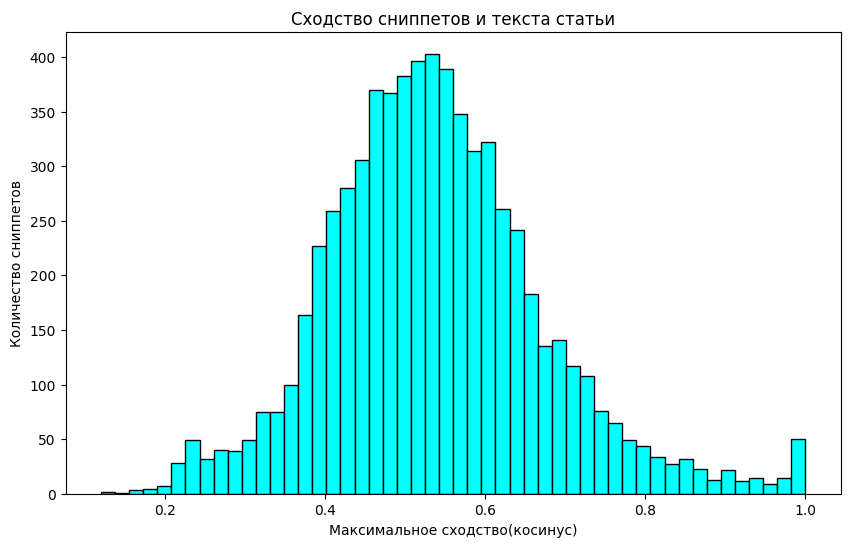

In [22]:
import json
import matplotlib.pyplot as plt

with open('max_sim_results.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

all_max_sim = []
for article in results.values():
    for detail in article['details']:
        all_max_sim.append(detail['max_sim'])

plt.figure(figsize=(10, 6))
plt.hist(all_max_sim, bins=50, color = 'cyan', edgecolor='black')
plt.title('Сходство сниппетов и текста статьи')
plt.xlabel('Максимальное сходство(косинус)')
plt.ylabel('Количество сниппетов')
plt.grid(False)
plt.show()

In [6]:
for name in wiki_bench.article_names:
    print(name)
    page = wiki_bench.get_article(name, is_downloaded=True)
    await wiki_bench.wiki_evaluater.rank_outline(name, mode=1, page=page, neighbor_count=0, description_mode=0)

Python
found snippets:  784
emb len:  784
Count of emb ids:  76
Downloaded docs:  {'cite_note-_995b6156384c43a7-16': 1, 'cite_note-AutoNT-2-10': 2, 'cite_note-effbot-call-by-object-9': 3, 'cite_note-_d0f8d8a689287635-17': 4, 'cite_note-98-interview-5': 5, 'cite_note-faq-created-3': 6, 'cite_note-_8406e6c0afbf6fdf-18': 7, 'cite_note-_31adfebf6a01c187-15': 8, 'cite_note-_cc32a279a63274a3-20': 9, 'cite_note-_557c9342431fdc2d-1': 10, 'cite_note-AutoNT-4-12': 11, 'cite_note-28': 12, 'cite_note-python-8468-42': 13, 'cite_note-35': 14, 'cite_note-AutoNT-5-13': 15, 'cite_note-39': 16, 'cite_note-38': 17, 'cite_note-:1-27': 18, 'cite_note-classmix-8': 19, 'cite_note-AutoNT-24-51': 20, 'cite_note-_121bab8024e9d28f-19': 21, 'cite_note-56': 22, 'cite_note-50': 23, 'cite_note-:10-45': 24, 'cite_note-55': 25, 'cite_note-AutoNT-3-11': 26, 'cite_note-:14-47': 27, 'cite_note-_82f3fb81aba07547-22': 28, 'cite_note-48': 29, 'cite_note-AutoNT-59-59': 30, 'cite_note-foreword-81': 31, 'cite_note-76': 32, 'ci

In [27]:
import os

texts2 = []
for subdir, _, files in os.walk(r'Generation\Subqueries_ref\Annotations'):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(subdir, file)
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read()
                texts2.append(text.split('\n')[0])

In [26]:
print(names)

['C++', 'COVID-19', 'Dota 2', 'Google (компания)', 'Portal 2', 'Python', 'TikTok', 'Tomb Raider (игра, 2013)', 'Uncharted 4: A Thief’s End', 'YouTube', 'Большой адронный коллайдер', 'Вирус иммунодефицита человека', 'Геморрагическая лихорадка Эбола', 'Иннополис', 'Искусственный интеллект', 'Квантовый компьютер', 'Летние Олимпийские игры 2020', 'Летние Олимпийские игры 2024', 'Марс', 'Применение искусственного интеллекта', 'Присоединение Крыма к Российской Федерации', 'РИА Новости', 'Сбербанк России', 'Си (язык программирования)', 'Сколково (инновационный центр)', 'Солнечная система', 'Чёрная дыра', 'Чёрная смерть', 'Экономика КНР', 'Экономика США', 'Яндекс']


In [40]:
print(texts2[21])

Статья "РИА Новости" представляет собой обзор истории и деятельности одноимённого российского информационного агентства. В ней освещаются ключевые этапы развития агентства, включая его структуру до 2013 года и ликвидацию ФГУП РАМИ "РИА Новости". Кроме того, статья затрагивает темы, связанные с работой агентства на крупных мероприятиях, таких как Олимпиада в Сочи, а также проблемы, с которыми столкнулись журналисты при исполнении профессионального долга. Статья также рассматривает вопросы, связанные с санкциями и блокировкой агентства в отдельных странах, таких как Молдавия. В целом, статья дает всесторонний обзор деятельности и истории РИА Новости.


In [67]:
wiki_bench = WikiBench(url, key, model_name='tpro', pre_load=True)

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


In [ ]:
Model(id='tpro', created=None, object=None, owned_by=None, max_model_len=30000, status='spawned')
Model(id='yagpt5lite', created=None, object=None, owned_by=None, max_model_len=30000, status='spawned')
Model(id='RefalMachine/RuadaptQwen2.5-32B-Pro-Beta', created=None, object=None, owned_by=None, max_model_len=28000, status='spawned')
Model(id='RefalMachine/RuadaptQwen2.5-32B-QWQ-Beta', created=None, object=None, owned_by=None, max_model_len=16000, status='spawned')
Model(id='llama3-70b', created=None, object=None, owned_by=None, max_model_len=14000, status='spawned')
Model(id='qwen2.5-72b', created=None, object=None, owned_by=None, max_model_len=14000, status='spawned')
Model(id='RefalMachine/RuadaptQwen2.5-7B-Garant-v2', created=None, object=None, owned_by=None, max_model_len=30000, status='offloaded')
Model(id='RefalMachine/RuadaptQwen2.5-7B-Lite-Beta', created=None, object=None, owned_by=None, max_model_len=30000, status='offloaded')
Model(id='deepseek-r1-32b', created=None, object=None, owned_by=None, max_model_len=30000, status='offloaded')
Model(id='qwen32b-coder', created=None, object=None, owned_by=None, max_model_len=30000, status='offloaded')
Model(id='vikhr12b', created=None, object=None, owned_by=None, max_model_len=30000, status='offloaded')
Model(id='Nemotron49b', created=None, object=None, owned_by=None, max_model_len=16000, status='offloaded')
Model(id='tlite', created=None, object=None, owned_by=None, max_model_len=-1, status='offloaded')

In [68]:
from sentence_transformers import SentenceTransformer
import numpy as np


PROMPT = """
Ты — опытный редактор Википедии. На основе краткого описания статьи и ее названия тебе нужно составить короткий план всей статьи.
Пожалуйста, строго следуй этим инструкциям:
1. Начни план с названия интересующей темы "Topic"
2. Используй "# Title" для заголовков разделов, "## Title" для заголовков подразделов, "### Title" для подподразделов и так далее.
3. В конце плана напиши **END**
4. Ничего другого писать не нужно.

Тема статьи: {}
Описание статьи: {}
"""
model_embeddings = SentenceTransformer("sergeyzh/BERTA")
p = 0
r = 0
f = 0
count = 0
a = []
b = []
c = []
for name, text in zip(names, texts2):
    count += 1
    print(name)
    page = wiki_bench.get_article(name, False, True)
    myprompt = PROMPT.format(name, text)
    res = await wiki_bench.client.get_completion(myprompt)
    if res.choices is not None:
        response = res.choices[0].message.content.strip()
    else:
        print('Error!')
        continue
    outline = response
    parsed_headings = []
    for line in outline.split('\n'):
        line = line.strip()
        if line.startswith("#"):
            level = len(line) - len(line.lstrip("#"))
            title = line[level:].strip()
            if title:
                parsed_headings.append((level, title))
    heads = [head[1] for head in parsed_headings]
    pred_emb = model_embeddings.encode(heads, normalize_embeddings=True)
    true_heads = []
    for headings in page.filtered_outline.keys():
        true_heads.append(headings[1])
    ref_emb =  model_embeddings.encode(true_heads, normalize_embeddings=True)
    sims = pred_emb @ ref_emb.T
    precision_scores = sims.max(axis=1).mean()
    recall_scores = sims.max(axis=0).mean()
    if precision_scores + recall_scores == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision_scores * recall_scores / (precision_scores + recall_scores)
    p += precision_scores
    r += recall_scores
    f += f1
    a.append(precision_scores)
    b.append(recall_scores)
    c.append(f1)
    print(precision_scores, recall_scores, f1)
print(p / count, r / count, f / count)

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


C++
0.73895943 0.73998207 0.7394704
COVID-19
0.82927626 0.8021694 0.81549764
Dota 2
0.7436553 0.8785052 0.8054753
Google (компания)
0.7857456 0.75630057 0.77074194
Portal 2
0.7469662 0.80251527 0.77374506
Python
0.81863266 0.7961141 0.80721635
TikTok
0.7229557 0.6834162 0.70263016
Tomb Raider (игра, 2013)
0.8054377 0.78164595 0.7933635
Uncharted 4: A Thief’s End
0.77498615 0.8640586 0.8171021
YouTube
0.6753873 0.732163 0.7026301
Большой адронный коллайдер
0.7570621 0.6562817 0.70307875
Вирус иммунодефицита человека
0.78900635 0.7084751 0.74657536
Геморрагическая лихорадка Эбола
0.7956749 0.81653273 0.8059689
Иннополис
0.8002834 0.81979 0.8099193
Искусственный интеллект
0.7256788 0.7150952 0.7203481
Квантовый компьютер
0.73267645 0.77512956 0.7533054
Летние Олимпийские игры 2020
0.69711417 0.8802828 0.77806365
Летние Олимпийские игры 2024
0.74998575 0.819381 0.7831491
Марс
0.7787132 0.80061924 0.7895143
Применение искусственного интеллекта
0.76705825 0.7867975 0.77680254
Присоединение К

In [71]:
import numpy as np
from scipy.stats import bootstrap

def calc(data):
  data = np.array(data)
  data1 = (data,)
  bootstrap_ci = bootstrap(data1, np.mean, confidence_level=0.95, n_resamples=len(data)-1)

  dist = bootstrap_ci.bootstrap_distribution
  mean = np.quantile(dist, q=0.5)
  min = np.quantile(dist, q=0.025)
  max = np.quantile(dist, q=0.975)
  print(f"{100*mean:2.2f}")
  print(f"{100*min:2.2f}")
  print(f"{100*max:2.2f}")
  print()

calc(a)
calc(b)
calc(c)

76.54
75.39
77.30

76.75
75.29
78.50

76.51
75.52
77.64



In [70]:
import json

fixed_lst = [(float(a), float(b), float(c)) for a, b, c in zip(a, b, c)]
with open('tpro_outline.json', 'w', encoding='utf-8') as f:
    json.dump(fixed_lst, f, ensure_ascii=False, indent=2)

In [1]:
import sys

sys.path.append("src")
from wiki_bench import WikiBench
with open('Access_key.txt', 'r', encoding='utf-8') as file:
    url, key = file.read().split()

resource module not available on Windows


In [11]:
wiki_bench = WikiBench(url, key, model_name='yagpt5lite', pre_load=True)
lst = list(await wiki_bench.client.client.models.list())[0][1]
for l in lst:
    print(l)

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


Model(id='tpro', created=None, object=None, owned_by=None, max_model_len=30000, status='spawned')
Model(id='vikhr12b', created=None, object=None, owned_by=None, max_model_len=30000, status='spawned')
Model(id='yagpt5lite', created=None, object=None, owned_by=None, max_model_len=30000, status='spawned')
Model(id='RefalMachine/RuadaptQwen2.5-32B-Pro-Beta', created=None, object=None, owned_by=None, max_model_len=28000, status='spawned')
Model(id='qwen2.5-72b', created=None, object=None, owned_by=None, max_model_len=14000, status='spawned')
Model(id='RefalMachine/RuadaptQwen2.5-7B-Garant-v2', created=None, object=None, owned_by=None, max_model_len=30000, status='offloaded')
Model(id='RefalMachine/RuadaptQwen2.5-7B-Lite-Beta', created=None, object=None, owned_by=None, max_model_len=30000, status='offloaded')
Model(id='deepseek-r1-32b', created=None, object=None, owned_by=None, max_model_len=30000, status='offloaded')
Model(id='qwen32b-coder', created=None, object=None, owned_by=None, max_mo

In [14]:
from sentence_transformers import SentenceTransformer
import os
import razdel
from openai_utils import AsyncList

model = SentenceTransformer("sergeyzh/BERTA")

texts = []
for subdir, _, files in os.walk(r'Generation\Subqueries_ref\Annotations'):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(subdir, file)
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read()
                texts.append(text)

base_dir = os.path.join('Articles', 'Sources')
        
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

snippets = wiki_bench.wiki_evaluater.get_texts_from_disk()
topR = []
for folder in folders:
    snip = [1 if snippet[0] == folder else 0 for snippet in snippets.keys()]
    topR.append((folder, sum(snip)))
    
annotations = AsyncList()
for name, _ in topR:
    annotations.append(wiki_bench.wiki_writer.get_ref_subqueries(None, 0, 0, name))
    #annotations.append(wiki_bench.wiki_writer.get_ref_subqueries(None, 1, 0, name))

await annotations.complete_couroutines(batch_size=40)
annotations = await annotations.to_list()
new_texts = []
for i in range(0, len(annotations), 1):
    new_text = annotations[i]# + '\n' + annotations[i + 1]
    new_texts.append(new_text)

pr_scores = []
rec_scores = []
for text, new_text in zip(texts, new_texts):
    text_sents = [t.text for t in razdel.sentenize(text.split('\n')[0])]
    text_emb = model.encode(text_sents, normalize_embs=True)
    new_text_sents = [t.text for t in razdel.sentenize(new_text)]
    new_text_emb = model.encode(new_text_sents, normalize_embs=True)
    sims = new_text_emb @ text_emb.T
    precision_scores = sims.max(axis=1).mean()
    recall_scores = sims.max(axis=0).mean()
    pr_scores.append(precision_scores)
    rec_scores.append(recall_scores)

Default prompt name is set to 'Classification'. This prompt will be applied to all `encode()` calls, except if `encode()` is called with `prompt` or `prompt_name` parameters.


In [15]:
import numpy as np
from scipy.stats import bootstrap

def calc(data):
  data = np.array(data)
  data1 = (data,)
  bootstrap_ci = bootstrap(data1, np.mean, confidence_level=0.95, n_resamples=len(data)-1)

  dist = bootstrap_ci.bootstrap_distribution
  mean = np.quantile(dist, q=0.5)
  min = np.quantile(dist, q=0.025)
  max = np.quantile(dist, q=0.975)
  print(f"{100*mean:2.2f}")
  print(f"{100*min:2.2f}")
  print(f"{100*max:2.2f}")
  print()

elem_p = [el[0] for el in wiki_bench.outline_logger]
elem_r = [el[1] for el in wiki_bench.outline_logger]

calc(pr_scores)
calc(rec_scores)

72.54
70.83
74.86

68.98
67.40
70.66

